<a href="https://colab.research.google.com/github/HowardHNguyen/Data_Science_for_Healthcare/blob/main/Predict_and_Forecast_by_SARIMA_Prophet_Neural_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
df = pd.read_csv('/content/drive/MyDrive/data/flu-ili-byregion-fluseason_data.csv')

# California

## SARIMA

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df_California = df[df['region'] == 'California'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_California['ds'] = pd.to_datetime(df_California['ds'])
df_California = df_California.sort_values('ds')


In [76]:
df.head(6)

,season,date_code,weekending,region,Total_ILI,Total_Patients_Seen,Percent_ILI,Number_Providers_Reporting
0,2001-2002,200140,10/6/01,Bay Area,3,135,2.22,2
1,2001-2002,200140,10/6/01,California,25,1211,2.06,14
2,2001-2002,200140,10/6/01,Central,0,0,0.00,0
3,2001-2002,200140,10/6/01,Lower Southern,2,336,0.60,4
4,2001-2002,200140,10/6/01,Northern,20,529,3.78,4
5,2001-2002,200140,10/6/01,Upper Southern,0,211,0.00,4


In [77]:
df.isnull().sum()

season                        0
date_code                     0
weekending                    0
region                        0
Total_ILI                     0
Total_Patients_Seen           0
Percent_ILI                   0
Number_Providers_Reporting    0
dtype: int64

In [78]:
# Data splitting
train_size = int(len(df_California) * 0.8)
train_df = df_California[:train_size]
test_df = df_California[train_size:]


In [79]:
# Train SARIMA model
sarima_model = SARIMAX(train_df['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_fit = sarima_model.fit(disp=False)


In [80]:
# Predict and Forecast
# Validate on test set
sarima_forecast = sarima_fit.get_forecast(steps=len(test_df))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Extend the forecasts for the future period (5 years weekly)
forecast_horizon = 5 * 52  # 5 years weekly
sarima_future_forecast = sarima_fit.get_forecast(steps=forecast_horizon).predicted_mean


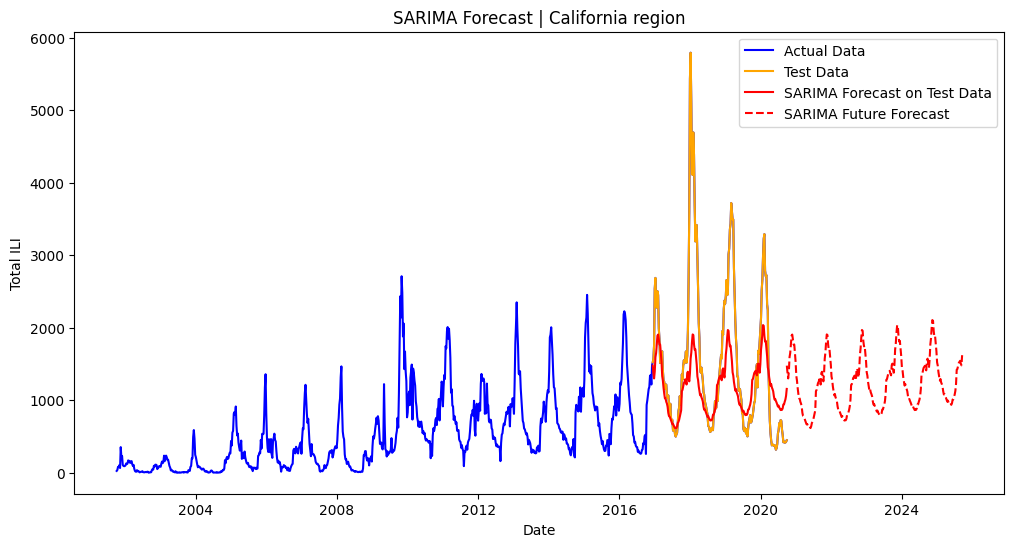

In [81]:
# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_California['ds'], df_California['y'], label='Actual Data', color='blue')

# Plot test data
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='orange')

# Plot forecasts on test data
plt.plot(test_df['ds'], sarima_forecast_mean, label='SARIMA Forecast on Test Data', color='red', linestyle='-')

# Plot future forecasts
future_dates = pd.date_range(start=test_df['ds'].max(), periods=forecast_horizon, freq='W')
plt.plot(future_dates, sarima_future_forecast, label='SARIMA Future Forecast', color='red', linestyle='--')

plt.title('SARIMA Forecast | California region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()


In [82]:
# Evaluate the model
# Calculate error metrics for SARIMA
sarima_mae = mean_absolute_error(test_df['y'], sarima_forecast_mean)
sarima_mse = mean_squared_error(test_df['y'], sarima_forecast_mean)
sarima_rmse = np.sqrt(sarima_mse)
sarima_accuracy = (1 - sarima_mae / np.mean(test_df['y'])) * 100

# Print error metrics
error_metrics_sarima = pd.DataFrame({
    'Model': ['SARIMA'],
    'MAE': [sarima_mae],
    'MSE': [sarima_mse],
    'RMSE': [sarima_rmse],
    'Accuracy (%)': [sarima_accuracy]
})

print(error_metrics_sarima)


    Model         MAE           MSE        RMSE  Accuracy (%)
0  SARIMA  571.393249  814073.94163  902.260462     62.769956


In [ ]:
# results of California
    Model         MAE           MSE      RMSE  Accuracy (%)
0  SARIMA  186.226115  72505.848482  269.2691     33.129438

## Prophet

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df_California = df[df['region'] == 'California'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_California['ds'] = pd.to_datetime(df_California['ds'])
df_California = df_California.sort_values('ds')


In [84]:
# Data splitting
train_size = int(len(df_California) * 0.8)
train_df = df_California[:train_size]
test_df = df_California[train_size:]


In [85]:
# Train FB Prophet model
prophet_model = Prophet()
prophet_model.fit(train_df)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxokenob/a1xxzmn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxokenob/ghxw2odr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76450', 'data', 'file=/tmp/tmpaxokenob/a1xxzmn2.json', 'init=/tmp/tmpaxokenob/ghxw2odr.json', 'output', 'file=/tmp/tmpaxokenob/prophet_modelai1jg5w9/prophet_model-20240528230511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:05:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:05:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [86]:
# Predict and Forecast
# Validate on test set
future_prophet = prophet_model.make_future_dataframe(periods=len(test_df), freq='W')
prophet_forecast = prophet_model.predict(future_prophet)
prophet_forecast_df = prophet_forecast[['ds', 'yhat']].tail(len(test_df))

# Extend the forecasts for the future period (5 years weekly)
forecast_horizon = 5 * 52  # 5 years weekly
future_prophet_extended = prophet_model.make_future_dataframe(periods=forecast_horizon, freq='W')
prophet_future_forecast = prophet_model.predict(future_prophet_extended)


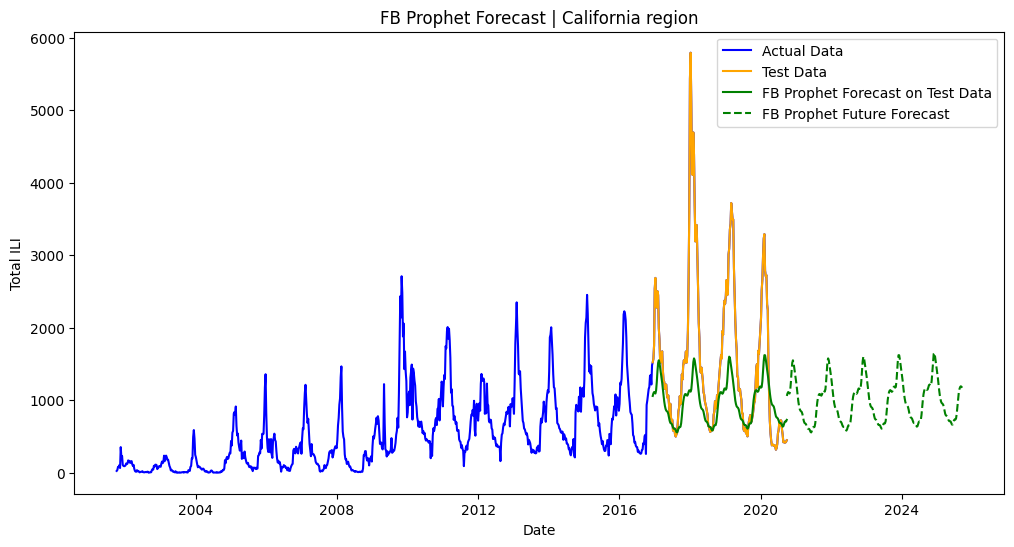

In [87]:
# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_California['ds'], df_California['y'], label='Actual Data', color='blue')

# Plot test data
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='orange')

# Plot forecasts on test data
plt.plot(test_df['ds'], prophet_forecast_df['yhat'], label='FB Prophet Forecast on Test Data', color='green', linestyle='-')

# Plot future forecasts
future_dates = pd.date_range(start=test_df['ds'].max(), periods=forecast_horizon, freq='W')
plt.plot(future_dates, prophet_future_forecast['yhat'][-forecast_horizon:], label='FB Prophet Future Forecast', color='green', linestyle='--')

plt.title('FB Prophet Forecast | California region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()


In [88]:
# Calculate error metrics for FB Prophet
prophet_mae = mean_absolute_error(test_df['y'], prophet_forecast_df['yhat'])
prophet_mse = mean_squared_error(test_df['y'], prophet_forecast_df['yhat'])
prophet_rmse = np.sqrt(prophet_mse)
prophet_accuracy = (1 - prophet_mae / np.mean(test_df['y'])) * 100

# Print error metrics
error_metrics_prophet = pd.DataFrame({
    'Model': ['FB Prophet'],
    'MAE': [prophet_mae],
    'MSE': [prophet_mse],
    'RMSE': [prophet_rmse],
    'Accuracy (%)': [prophet_accuracy]
})

print(error_metrics_prophet)


        Model        MAE           MSE         RMSE  Accuracy (%)
0  FB Prophet  659.34283  1.070620e+06  1034.707688      57.03946


## Neural Prophet

In [19]:
!pip install neuralprophet plotly pandas
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 19.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from neuralprophet import NeuralProphet
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df_California = df[df['region'] == 'California'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_California['ds'] = pd.to_datetime(df_California['ds'])
df_California = df_California.sort_values('ds')


In [90]:
# Data splitting
train_size = int(len(df_California) * 0.8)
train_df = df_California[:train_size]
test_df = df_California[train_size:]


In [91]:
# Train Neural Prophet model
neural_prophet_model = NeuralProphet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
neural_prophet_model.fit(train_df, freq='W')


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.874% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.874% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 120
INFO:NP.config:Auto-set epochs to 120
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (25) is too small than the required number

Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,2163.899658,2535.980225,1.018121,0.0,0
1,1790.319946,2145.494141,0.824046,0.0,1
2,1453.422241,1768.535767,0.647046,0.0,2
3,1154.297119,1409.552612,0.489938,0.0,3
4,919.904114,1123.064819,0.368161,0.0,4
...,...,...,...,...,...
115,179.542221,263.127350,0.034956,0.0,115
116,179.737396,268.301849,0.035073,0.0,116
117,178.805405,261.284027,0.034589,0.0,117
118,178.933960,263.320068,0.034630,0.0,118


In [92]:
# Predict and Forecast
# Validate on test set
future_neuralprophet_df = neural_prophet_model.make_future_dataframe(train_df, periods=len(test_df), n_historic_predictions=False)
neuralprophet_forecast = neural_prophet_model.predict(future_neuralprophet_df)
neuralprophet_forecast_df = neuralprophet_forecast[['ds', 'yhat1']].tail(len(test_df)).rename(columns={'yhat1': 'yhat'})

# Extend the forecasts for the future period (5 years weekly)
forecast_horizon = 5 * 52  # 5 years weekly
future_neuralprophet_df_extended = neural_prophet_model.make_future_dataframe(train_df, periods=forecast_horizon, n_historic_predictions=False)
neuralprophet_future_forecast = neural_prophet_model.predict(future_neuralprophet_df_extended)


INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.874% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.874% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.497% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.497% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.497% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.497% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 25it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.874% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.874% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.615% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.615% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 9

Predicting: 25it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


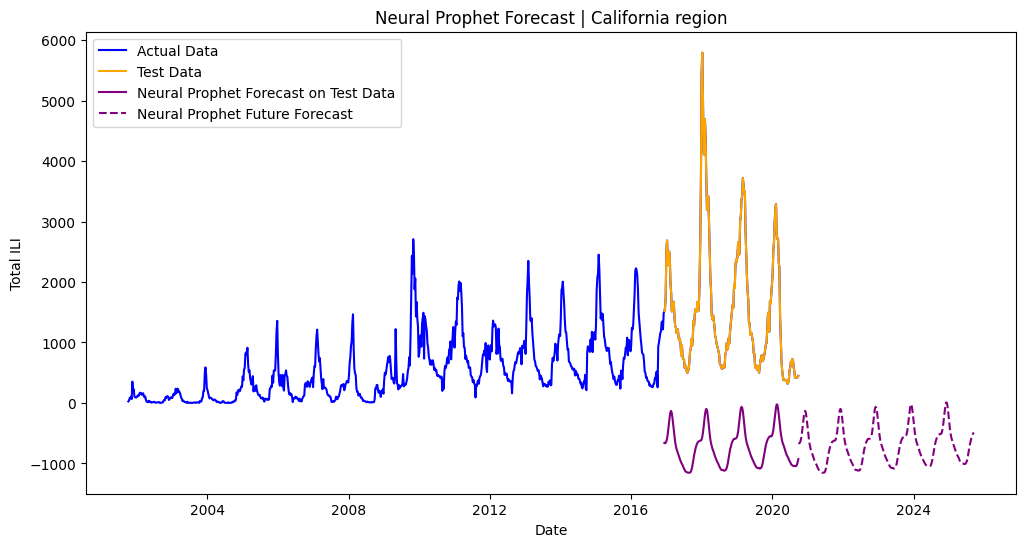

In [93]:
# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_California['ds'], df_California['y'], label='Actual Data', color='blue')

# Plot test data
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='orange')

# Plot forecasts on test data
plt.plot(test_df['ds'], neuralprophet_forecast_df['yhat'], label='Neural Prophet Forecast on Test Data', color='purple', linestyle='-')

# Plot future forecasts
future_dates = pd.date_range(start=test_df['ds'].max(), periods=forecast_horizon, freq='W')
plt.plot(future_dates, neuralprophet_future_forecast['yhat1'][-forecast_horizon:], label='Neural Prophet Future Forecast', color='purple', linestyle='--')

plt.title('Neural Prophet Forecast | California region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()


In [94]:
# Calculate error metrics for Neural Prophet
neuralprophet_mae = mean_absolute_error(test_df['y'], neuralprophet_forecast_df['yhat'])
neuralprophet_mse = mean_squared_error(test_df['y'], neuralprophet_forecast_df['yhat'])
neuralprophet_rmse = np.sqrt(neuralprophet_mse)
neuralprophet_accuracy = (1 - neuralprophet_mae / np.mean(test_df['y'])) * 100

# Print error metrics
error_metrics_neuralprophet = pd.DataFrame({
    'Model': ['Neural Prophet'],
    'MAE': [neuralprophet_mae],
    'MSE': [neuralprophet_mse],
    'RMSE': [neuralprophet_rmse],
    'Accuracy (%)': [neuralprophet_accuracy]
})

print(error_metrics_neuralprophet)


            Model          MAE           MSE         RMSE  Accuracy (%)
0  Neural Prophet  2263.776209  5.859794e+06  2420.701071    -47.499972


# Bay Area

## SARIMA

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df_bay_area = df[df['region'] == 'Bay Area'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_bay_area['ds'] = pd.to_datetime(df_bay_area['ds'])
df_bay_area = df_bay_area.sort_values('ds')


In [96]:
# Data splitting
train_size = int(len(df_bay_area) * 0.8)
train_df = df_bay_area[:train_size]
test_df = df_bay_area[train_size:]


In [97]:
# Train SARIMA model
sarima_model = SARIMAX(train_df['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_fit = sarima_model.fit(disp=False)


In [98]:
# Predict and Forecast
# Validate on test set
sarima_forecast = sarima_fit.get_forecast(steps=len(test_df))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Extend the forecasts for the future period (5 years weekly)
forecast_horizon = 5 * 52  # 5 years weekly
sarima_future_forecast = sarima_fit.get_forecast(steps=forecast_horizon).predicted_mean


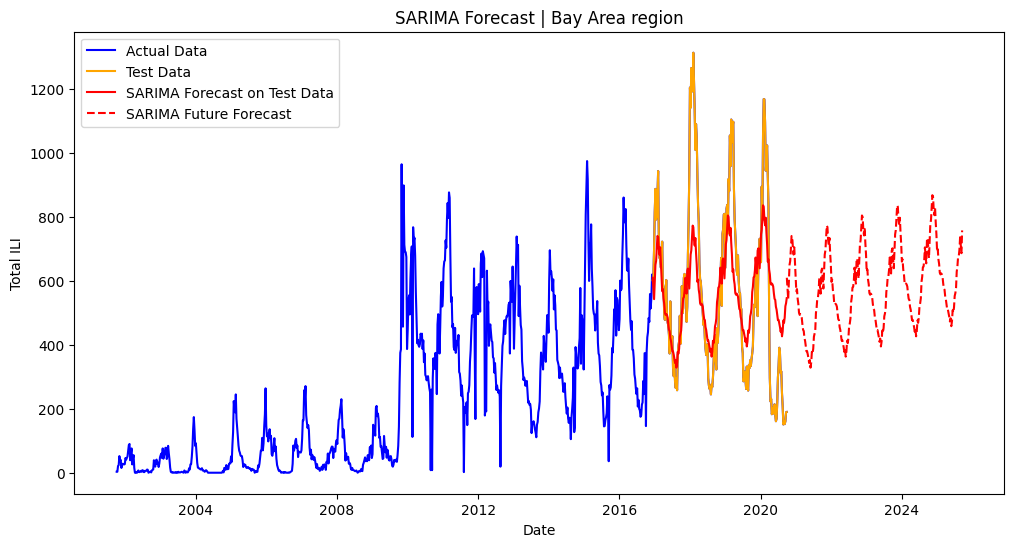

In [99]:
# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_bay_area['ds'], df_bay_area['y'], label='Actual Data', color='blue')

# Plot test data
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='orange')

# Plot forecasts on test data
plt.plot(test_df['ds'], sarima_forecast_mean, label='SARIMA Forecast on Test Data', color='red', linestyle='-')

# Plot future forecasts
future_dates = pd.date_range(start=test_df['ds'].max(), periods=forecast_horizon, freq='W')
plt.plot(future_dates, sarima_future_forecast, label='SARIMA Future Forecast', color='red', linestyle='--')

plt.title('SARIMA Forecast | Bay Area region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()


In [100]:
# Evaluate the model
# Calculate error metrics for SARIMA
sarima_mae = mean_absolute_error(test_df['y'], sarima_forecast_mean)
sarima_mse = mean_squared_error(test_df['y'], sarima_forecast_mean)
sarima_rmse = np.sqrt(sarima_mse)
sarima_accuracy = (1 - sarima_mae / np.mean(test_df['y'])) * 100

# Print error metrics
error_metrics_sarima = pd.DataFrame({
    'Model': ['SARIMA'],
    'MAE': [sarima_mae],
    'MSE': [sarima_mse],
    'RMSE': [sarima_rmse],
    'Accuracy (%)': [sarima_accuracy]
})

print(error_metrics_sarima)


    Model         MAE          MSE       RMSE  Accuracy (%)
0  SARIMA  150.367788  40715.91096  201.78184     73.616895


## Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxokenob/cioxwqa_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxokenob/svhsx1_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3077', 'data', 'file=/tmp/tmpaxokenob/cioxwqa_.json', 'init=/tmp/tmpaxokenob/svhsx1_l.json', 'output', 'file=/tmp/tmpaxokenob/prophet_model9nlfqi6n/prophet_model-20240528231754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:17:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:17:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


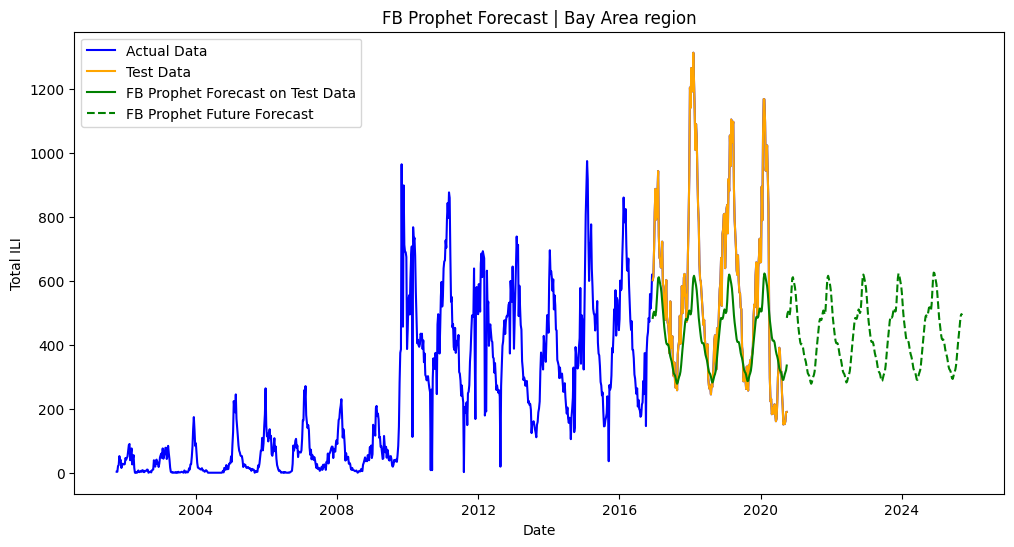

        Model         MAE           MSE        RMSE  Accuracy (%)
0  FB Prophet  179.808814  60260.561672  245.480267     68.451257


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df_bay_area = df[df['region'] == 'Bay Area'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_bay_area['ds'] = pd.to_datetime(df_bay_area['ds'])
df_bay_area = df_bay_area.sort_values('ds')

# Data splitting
train_size = int(len(df_bay_area) * 0.8)
train_df = df_bay_area[:train_size]
test_df = df_bay_area[train_size:]

# Train FB Prophet model
prophet_model = Prophet()
prophet_model.fit(train_df)

# Predict and Forecast
# Validate on test set
future_prophet = prophet_model.make_future_dataframe(periods=len(test_df), freq='W')
prophet_forecast = prophet_model.predict(future_prophet)
prophet_forecast_df = prophet_forecast[['ds', 'yhat']].tail(len(test_df))

# Extend the forecasts for the future period (5 years weekly)
forecast_horizon = 5 * 52  # 5 years weekly
future_prophet_extended = prophet_model.make_future_dataframe(periods=forecast_horizon, freq='W')
prophet_future_forecast = prophet_model.predict(future_prophet_extended)

# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_bay_area['ds'], df_bay_area['y'], label='Actual Data', color='blue')

# Plot test data
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='orange')

# Plot forecasts on test data
plt.plot(test_df['ds'], prophet_forecast_df['yhat'], label='FB Prophet Forecast on Test Data', color='green', linestyle='-')

# Plot future forecasts
future_dates = pd.date_range(start=test_df['ds'].max(), periods=forecast_horizon, freq='W')
plt.plot(future_dates, prophet_future_forecast['yhat'][-forecast_horizon:], label='FB Prophet Future Forecast', color='green', linestyle='--')

plt.title('FB Prophet Forecast | Bay Area region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()

# Calculate error metrics for FB Prophet
prophet_mae = mean_absolute_error(test_df['y'], prophet_forecast_df['yhat'])
prophet_mse = mean_squared_error(test_df['y'], prophet_forecast_df['yhat'])
prophet_rmse = np.sqrt(prophet_mse)
prophet_accuracy = (1 - prophet_mae / np.mean(test_df['y'])) * 100

# Print error metrics
error_metrics_prophet = pd.DataFrame({
    'Model': ['FB Prophet'],
    'MAE': [prophet_mae],
    'MSE': [prophet_mse],
    'RMSE': [prophet_rmse],
    'Accuracy (%)': [prophet_accuracy]
})

print(error_metrics_prophet)


## Neural Prophet

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.874% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.874% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 120
INFO:NP.config:Auto-set epochs to 120
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (25) is too small than the required number

Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.874% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.874% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.497% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.497% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.497% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.497% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 25it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.874% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.874% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.615% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.615% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 9

Predicting: 25it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


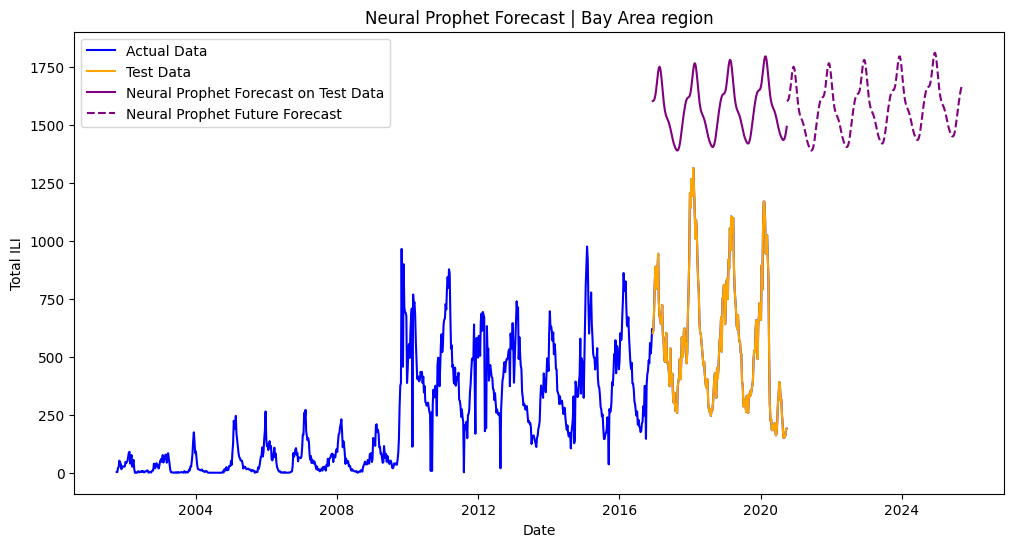

            Model         MAE           MSE         RMSE  Accuracy (%)
0  Neural Prophet  998.192364  1.035643e+06  1017.665299    -75.139996


In [102]:
# !pip install neuralprophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from neuralprophet import NeuralProphet
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df_bay_area = df[df['region'] == 'Bay Area'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_bay_area['ds'] = pd.to_datetime(df_bay_area['ds'])
df_bay_area = df_bay_area.sort_values('ds')

# Data splitting
train_size = int(len(df_bay_area) * 0.8)
train_df = df_bay_area[:train_size]
test_df = df_bay_area[train_size:]

# Train Neural Prophet model
neural_prophet_model = NeuralProphet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
neural_prophet_model.fit(train_df, freq='W')

# Predict and Forecast
# Validate on test set
future_neuralprophet_df = neural_prophet_model.make_future_dataframe(train_df, periods=len(test_df), n_historic_predictions=False)
neuralprophet_forecast = neural_prophet_model.predict(future_neuralprophet_df)
neuralprophet_forecast_df = neuralprophet_forecast[['ds', 'yhat1']].tail(len(test_df)).rename(columns={'yhat1': 'yhat'})

# Extend the forecasts for the future period (5 years weekly)
forecast_horizon = 5 * 52  # 5 years weekly
future_neuralprophet_df_extended = neural_prophet_model.make_future_dataframe(train_df, periods=forecast_horizon, n_historic_predictions=False)
neuralprophet_future_forecast = neural_prophet_model.predict(future_neuralprophet_df_extended)

# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_bay_area['ds'], df_bay_area['y'], label='Actual Data', color='blue')

# Plot test data
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='orange')

# Plot forecasts on test data
plt.plot(test_df['ds'], neuralprophet_forecast_df['yhat'], label='Neural Prophet Forecast on Test Data', color='purple', linestyle='-')

# Plot future forecasts
future_dates = pd.date_range(start=test_df['ds'].max(), periods=forecast_horizon, freq='W')
plt.plot(future_dates, neuralprophet_future_forecast['yhat1'][-forecast_horizon:], label='Neural Prophet Future Forecast', color='purple', linestyle='--')

plt.title('Neural Prophet Forecast | Bay Area region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()

# Calculate error metrics for Neural Prophet
neuralprophet_mae = mean_absolute_error(test_df['y'], neuralprophet_forecast_df['yhat'])
neuralprophet_mse = mean_squared_error(test_df['y'], neuralprophet_forecast_df['yhat'])
neuralprophet_rmse = np.sqrt(neuralprophet_mse)
neuralprophet_accuracy = (1 - neuralprophet_mae / np.mean(test_df['y'])) * 100

# Print error metrics
error_metrics_neuralprophet = pd.DataFrame({
    'Model': ['Neural Prophet'],
    'MAE': [neuralprophet_mae],
    'MSE': [neuralprophet_mse],
    'RMSE': [neuralprophet_rmse],
    'Accuracy (%)': [neuralprophet_accuracy]
})

print(error_metrics_neuralprophet)



# Northern

## SARIMA

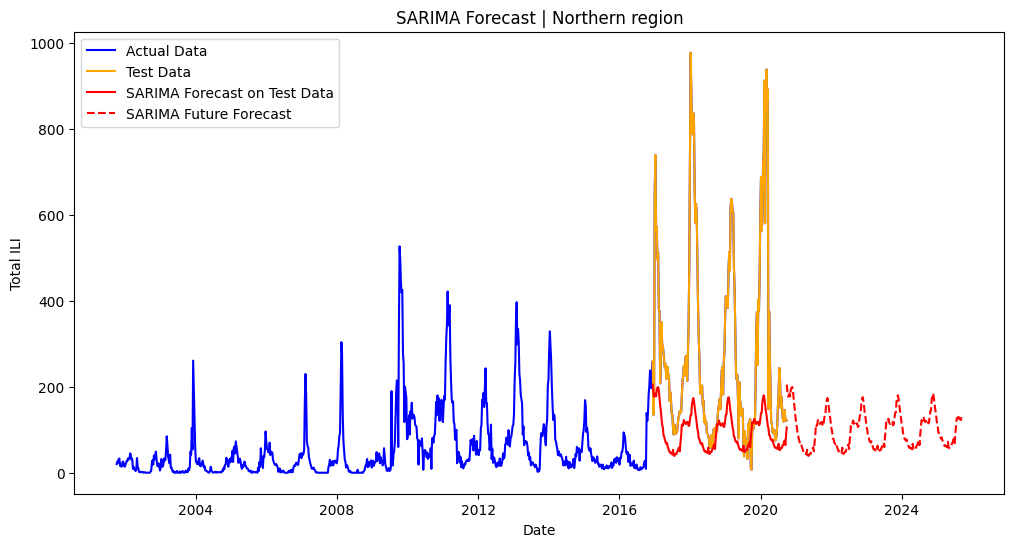

    Model         MAE           MSE      RMSE  Accuracy (%)
0  SARIMA  186.226115  72505.848482  269.2691     33.129438


In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df_northern = df[df['region'] == 'Northern'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_northern['ds'] = pd.to_datetime(df_northern['ds'])
df_northern = df_northern.sort_values('ds')

# Data splitting
train_size = int(len(df_northern) * 0.8)
train_df = df_northern[:train_size]
test_df = df_northern[train_size:]

# Train SARIMA model
sarima_model = SARIMAX(train_df['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_fit = sarima_model.fit(disp=False)

# Predict and Forecast
# Validate on test set
sarima_forecast = sarima_fit.get_forecast(steps=len(test_df))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Extend the forecasts for the future period (5 years weekly)
forecast_horizon = 5 * 52  # 5 years weekly
sarima_future_forecast = sarima_fit.get_forecast(steps=forecast_horizon).predicted_mean

# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_northern['ds'], df_northern['y'], label='Actual Data', color='blue')

# Plot test data
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='orange')

# Plot forecasts on test data
plt.plot(test_df['ds'], sarima_forecast_mean, label='SARIMA Forecast on Test Data', color='red', linestyle='-')

# Plot future forecasts
future_dates = pd.date_range(start=test_df['ds'].max(), periods=forecast_horizon, freq='W')
plt.plot(future_dates, sarima_future_forecast, label='SARIMA Future Forecast', color='red', linestyle='--')

plt.title('SARIMA Forecast | Northern region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()

# Evaluate the model
# Calculate error metrics for SARIMA
sarima_mae = mean_absolute_error(test_df['y'], sarima_forecast_mean)
sarima_mse = mean_squared_error(test_df['y'], sarima_forecast_mean)
sarima_rmse = np.sqrt(sarima_mse)
sarima_accuracy = (1 - sarima_mae / np.mean(test_df['y'])) * 100

# Print error metrics
error_metrics_sarima = pd.DataFrame({
    'Model': ['SARIMA'],
    'MAE': [sarima_mae],
    'MSE': [sarima_mse],
    'RMSE': [sarima_rmse],
    'Accuracy (%)': [sarima_accuracy]
})

print(error_metrics_sarima)



## Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxokenob/ur7cpqx9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaxokenob/t2lu9sqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72806', 'data', 'file=/tmp/tmpaxokenob/ur7cpqx9.json', 'init=/tmp/tmpaxokenob/t2lu9sqn.json', 'output', 'file=/tmp/tmpaxokenob/prophet_model9l1m__dw/prophet_model-20240528232916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:29:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:29:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


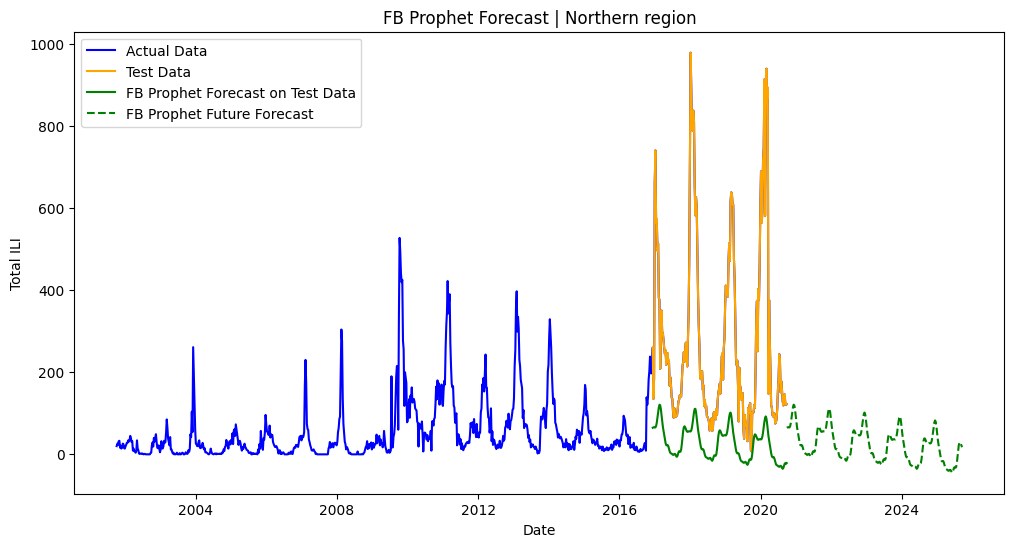

        Model         MAE           MSE        RMSE  Accuracy (%)
0  FB Prophet  250.935586  102194.45681  319.678677      9.893391


In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df_northern = df[df['region'] == 'Northern'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_northern['ds'] = pd.to_datetime(df_northern['ds'])
df_northern = df_northern.sort_values('ds')

# Data splitting
train_size = int(len(df_northern) * 0.8)
train_df = df_northern[:train_size]
test_df = df_northern[train_size:]

# Train FB Prophet model
prophet_model = Prophet()
prophet_model.fit(train_df)

# Predict and Forecast
# Validate on test set
future_prophet = prophet_model.make_future_dataframe(periods=len(test_df), freq='W')
prophet_forecast = prophet_model.predict(future_prophet)
prophet_forecast_df = prophet_forecast[['ds', 'yhat']].tail(len(test_df))

# Extend the forecasts for the future period (5 years weekly)
forecast_horizon = 5 * 52  # 5 years weekly
future_prophet_extended = prophet_model.make_future_dataframe(periods=forecast_horizon, freq='W')
prophet_future_forecast = prophet_model.predict(future_prophet_extended)

# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_northern['ds'], df_northern['y'], label='Actual Data', color='blue')

# Plot test data
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='orange')

# Plot forecasts on test data
plt.plot(test_df['ds'], prophet_forecast_df['yhat'], label='FB Prophet Forecast on Test Data', color='green', linestyle='-')

# Plot future forecasts
future_dates = pd.date_range(start=test_df['ds'].max(), periods=forecast_horizon, freq='W')
plt.plot(future_dates, prophet_future_forecast['yhat'][-forecast_horizon:], label='FB Prophet Future Forecast', color='green', linestyle='--')

plt.title('FB Prophet Forecast | Northern region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()

# Calculate error metrics for FB Prophet
prophet_mae = mean_absolute_error(test_df['y'], prophet_forecast_df['yhat'])
prophet_mse = mean_squared_error(test_df['y'], prophet_forecast_df['yhat'])
prophet_rmse = np.sqrt(prophet_mse)
prophet_accuracy = (1 - prophet_mae / np.mean(test_df['y'])) * 100

# Print error metrics
error_metrics_prophet = pd.DataFrame({
    'Model': ['FB Prophet'],
    'MAE': [prophet_mae],
    'MSE': [prophet_mse],
    'RMSE': [prophet_rmse],
    'Accuracy (%)': [prophet_accuracy]
})

print(error_metrics_prophet)



## Neural Prophet

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.874% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.874% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 120
INFO:NP.config:Auto-set epochs to 120
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (25) is too small than the required number

Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.874% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.874% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.497% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.497% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.497% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.497% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 25it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.874% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.874% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.615% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.615% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 9

Predicting: 25it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


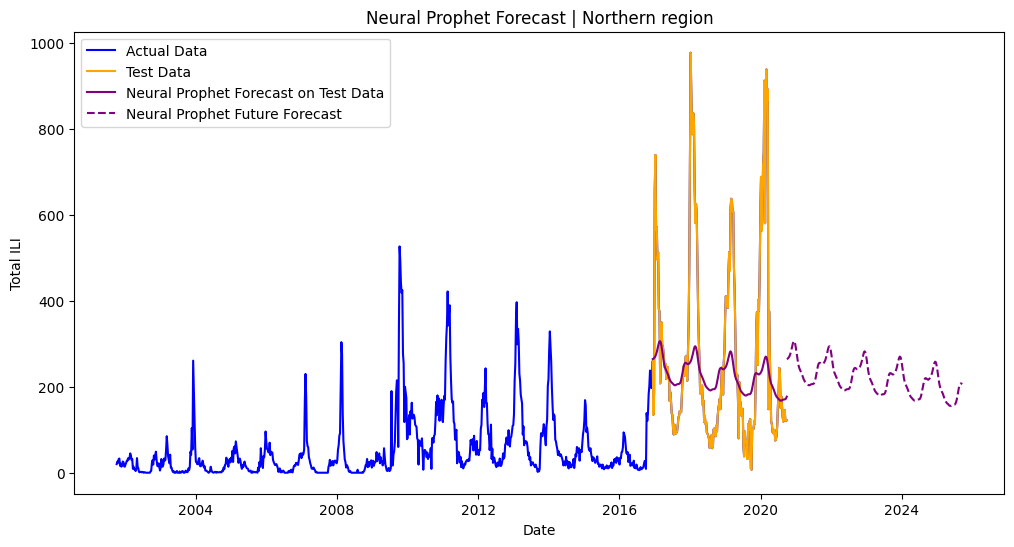

            Model         MAE           MSE        RMSE  Accuracy (%)
0  Neural Prophet  139.307574  42995.665387  207.353962     49.977071


In [105]:
# !pip install neuralprophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from neuralprophet import NeuralProphet
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df_northern = df[df['region'] == 'Northern'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_northern['ds'] = pd.to_datetime(df_northern['ds'])
df_northern = df_northern.sort_values('ds')

# Data splitting
train_size = int(len(df_northern) * 0.8)
train_df = df_northern[:train_size]
test_df = df_northern[train_size:]

# Train Neural Prophet model
neural_prophet_model = NeuralProphet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
neural_prophet_model.fit(train_df, freq='W')

# Predict and Forecast
# Validate on test set
future_neuralprophet_df = neural_prophet_model.make_future_dataframe(train_df, periods=len(test_df), n_historic_predictions=False)
neuralprophet_forecast = neural_prophet_model.predict(future_neuralprophet_df)
neuralprophet_forecast_df = neuralprophet_forecast[['ds', 'yhat1']].tail(len(test_df)).rename(columns={'yhat1': 'yhat'})

# Extend the forecasts for the future period (5 years weekly)
forecast_horizon = 5 * 52  # 5 years weekly
future_neuralprophet_df_extended = neural_prophet_model.make_future_dataframe(train_df, periods=forecast_horizon, n_historic_predictions=False)
neuralprophet_future_forecast = neural_prophet_model.predict(future_neuralprophet_df_extended)

# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_northern['ds'], df_northern['y'], label='Actual Data', color='blue')

# Plot test data
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='orange')

# Plot forecasts on test data
plt.plot(test_df['ds'], neuralprophet_forecast_df['yhat'], label='Neural Prophet Forecast on Test Data', color='purple', linestyle='-')

# Plot future forecasts
future_dates = pd.date_range(start=test_df['ds'].max(), periods=forecast_horizon, freq='W')
plt.plot(future_dates, neuralprophet_future_forecast['yhat1'][-forecast_horizon:], label='Neural Prophet Future Forecast', color='purple', linestyle='--')

plt.title('Neural Prophet Forecast | Northern region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()

# Calculate error metrics for Neural Prophet
neuralprophet_mae = mean_absolute_error(test_df['y'], neuralprophet_forecast_df['yhat'])
neuralprophet_mse = mean_squared_error(test_df['y'], neuralprophet_forecast_df['yhat'])
neuralprophet_rmse = np.sqrt(neuralprophet_mse)
neuralprophet_accuracy = (1 - neuralprophet_mae / np.mean(test_df['y'])) * 100

# Print error metrics
error_metrics_neuralprophet = pd.DataFrame({
    'Model': ['Neural Prophet'],
    'MAE': [neuralprophet_mae],
    'MSE': [neuralprophet_mse],
    'RMSE': [neuralprophet_rmse],
    'Accuracy (%)': [neuralprophet_accuracy]
})

print(error_metrics_neuralprophet)


# Central

## SARIMA

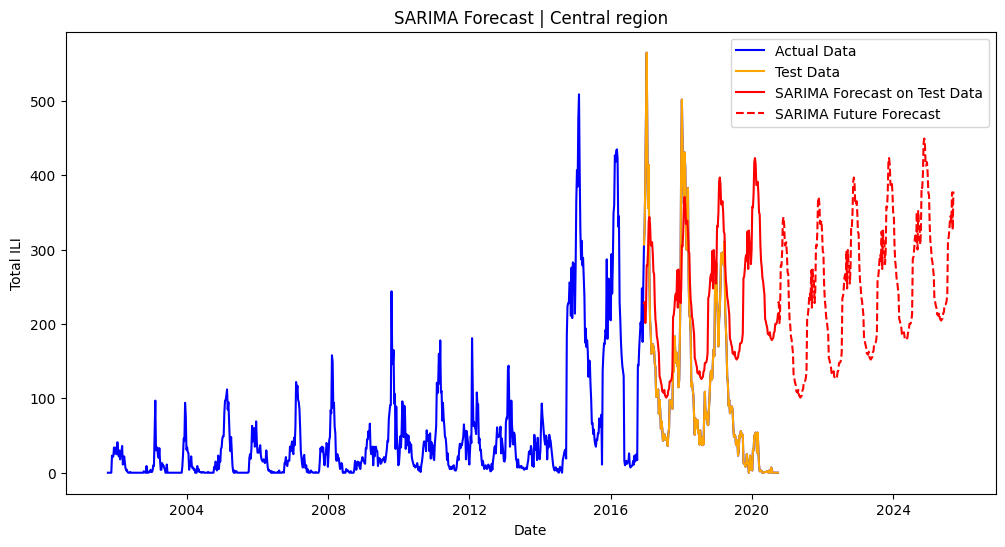

    Model         MAE           MSE        RMSE  Accuracy (%)
0  SARIMA  134.974681  26414.526345  162.525464    -14.234515


In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df_central = df[df['region'] == 'Central'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_central['ds'] = pd.to_datetime(df_central['ds'])
df_central = df_central.sort_values('ds')

# Data splitting
train_size = int(len(df_central) * 0.8)
train_df = df_central[:train_size]
test_df = df_central[train_size:]

# Train SARIMA model
sarima_model = SARIMAX(train_df['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_fit = sarima_model.fit(disp=False)

# Predict and Forecast
# Validate on test set
sarima_forecast = sarima_fit.get_forecast(steps=len(test_df))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Extend the forecasts for the future period (5 years weekly)
forecast_horizon = 5 * 52  # 5 years weekly
sarima_future_forecast = sarima_fit.get_forecast(steps=forecast_horizon).predicted_mean

# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_central['ds'], df_central['y'], label='Actual Data', color='blue')

# Plot test data
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='orange')

# Plot forecasts on test data
plt.plot(test_df['ds'], sarima_forecast_mean, label='SARIMA Forecast on Test Data', color='red', linestyle='-')

# Plot future forecasts
future_dates = pd.date_range(start=test_df['ds'].max(), periods=forecast_horizon, freq='W')
plt.plot(future_dates, sarima_future_forecast, label='SARIMA Future Forecast', color='red', linestyle='--')

plt.title('SARIMA Forecast | Central region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()

# Evaluate the model
# Calculate error metrics for SARIMA
sarima_mae = mean_absolute_error(test_df['y'], sarima_forecast_mean)
sarima_mse = mean_squared_error(test_df['y'], sarima_forecast_mean)
sarima_rmse = np.sqrt(sarima_mse)
sarima_accuracy = (1 - sarima_mae / np.mean(test_df['y'])) * 100

# Print error metrics
error_metrics_sarima = pd.DataFrame({
    'Model': ['SARIMA'],
    'MAE': [sarima_mae],
    'MSE': [sarima_mse],
    'RMSE': [sarima_rmse],
    'Accuracy (%)': [sarima_accuracy]
})

print(error_metrics_sarima)